# Install Libraries

In [ ]:
# !pip install tensorflow pandas numpy sklearn
# !pip install pandas scikit-learn
# !pip install lime shap

# Import Libraries

In [19]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.metrics import AUC, Precision, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pandas.tseries.offsets import DateOffset
from sklearn import metrics

# Read Preprocessed Data

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
file_path_AU_preprocessed = '/content/drive/MyDrive/CKD/GitHub/data/preprocessed/AU/AU_preprocessed_df.csv'
file_path_JP_preprocessed = '/content/drive/MyDrive/CKD/GitHub/data/preprocessed/JP/JP_preprocessed_df.csv'

# Preparing for Tree Based Model

## Pre-processing Australian Dataset for tree based models

In [22]:
def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    return LinearRegression().fit(x, y).coef_[0]

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

def process_au_dataframe(file_path):
    AU_df = pd.read_csv(file_path)
    AU_df['COLLECTED'] = pd.to_datetime(AU_df['COLLECTED'])
    AU_df = AU_df.reset_index(drop=True)

    # Convert 'COLLECTED' to float for calculation purposes
    AU_df['COLLECTED'] = AU_df['COLLECTED'].apply(datetime_to_float)

    # Group the DataFrame by 'ID'
    grouped = AU_df.groupby('ID')

    # Compute slopes for each group and directly assign them to the DataFrame
    AU_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']

    # Calculate mean and std for eGFR
    AU_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
    AU_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

    # Fill any NaN values that might have cropped up during calculation
    AU_df.fillna(0, inplace=True)

    return AU_df

## Pre-processing Japanese Dataset for tree based models

In [23]:
# Function to convert Time to months
def convert_to_months(time_str):
    if time_str == 'eGFR(last visit)':
        return 42
    else:
        return int(time_str.split('(')[-1].split('M')[0])

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    model = LinearRegression().fit(x, y)
    return model.coef_[0]

def process_dataframe(file_path):
    JP_df = pd.read_csv(file_path)
    JP_df = JP_df.reset_index(drop=True)

    # Apply the function to the 'Time' column to create a new 'Months' column
    JP_df['Months'] = JP_df['Time'].apply(convert_to_months)

    # Assume a starting date for all IDs
    start_date = pd.Timestamp('2020-01-01')

    # Create a 'COLLECTED' column based on the 'Months' column
    JP_df['COLLECTED'] = JP_df.apply(lambda row: start_date + DateOffset(months=row['Months']), axis=1)

    # Convert 'COLLECTED' to float for calculation purposes
    JP_df['COLLECTED'] = JP_df['COLLECTED'].apply(datetime_to_float)

    # Group the DataFrame by 'ID' and calculate slopes, mean, and std for eGFR
    grouped = JP_df.groupby('ID')
    JP_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']
    JP_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
    JP_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

    # Fill any NaN values that might have cropped up during calculation
    JP_df.fillna(0, inplace=True)

    return JP_df

# Train and Evaluate Models

### TUNED HYPERPARAMTER MODEL - AU Dataset

In [24]:
AU_df = process_au_dataframe(file_path_AU_preprocessed)
AU_df

<ipython-input-22-4d83e8953e0a>:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  AU_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']


,COLLECTED,ID,SEX,AGE,eGFR,Kidney_Failure,eGFR_slope,eGFR_mean,eGFR_std
0,737062.510417,2,1,45,23,1,-0.045462,18.055556,2.099642
1,737098.010417,2,1,46,19,1,-0.045462,18.055556,2.099642
2,737100.036806,2,1,46,17,1,-0.045462,18.055556,2.099642
3,737115.687500,2,1,46,15,1,-0.045462,18.055556,2.099642
4,737122.458333,2,1,46,15,1,-0.045462,18.055556,2.099642
...,...,...,...,...,...,...,...,...,...
154511,738609.187500,149302,1,84,55,0,-2.396167,52.666667,2.516611
154512,738610.229167,149302,1,84,50,0,-2.396167,52.666667,2.516611
154513,738608.819444,149311,1,72,55,0,-3.435050,50.666667,3.785939
154514,738609.329167,149311,1,72,48,0,-3.435050,50.666667,3.785939


In [25]:
# Check the best seed value

# Adjust this threshold as needed
threshold = 0.5

# Create an empty dictionary to store ensemble components as well as their test statistics
ensemble = {}

features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X = AU_df[features]
y = AU_df['Kidney_Failure']

# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'TPR', 'TNR', 'FPR', 'FNR', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'ROC-AUC'])

# Here we are varying the training and testing sets
for seed_value in range(10):
    random.seed(seed_value)
    np.random.seed(seed_value)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed_value, stratify=y)

    # Define the model
    model = lgb.LGBMClassifier(random_state=seed_value)
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)
    predicted_probabilities = model.predict_proba(X_test)[:,1]  # Assuming class 1 is the positive class

    # Apply threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Compute statistics
    true_positives = np.sum((predicted_labels == 1) & (y_test == 1))
    true_negatives = np.sum((predicted_labels == 0) & (y_test == 0))
    false_positives = np.sum((predicted_labels == 1) & (y_test == 0))
    false_negatives = np.sum((predicted_labels == 0) & (y_test == 1))

    tpr = true_positives / (true_positives + false_negatives)
    tnr = true_negatives / (true_negatives + false_positives)
    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    precision = precision_score(y_test, predicted_labels)
    recall = recall_score(y_test, predicted_labels)
    specificity = tnr
    roc_auc = roc_auc_score(y_test, predicted_probabilities)

    df_results.loc[seed_value] = [true_positives, true_negatives, false_positives, false_negatives, tpr, tnr, fpr, fnr, accuracy, precision, recall, specificity, roc_auc]

    ensemble[seed_value] = {'model': model,
                            'test_statistics': {'true_positives': true_positives,
                                                'true_negatives': true_negatives,
                                                'false_positives': false_positives,
                                                'false_negatives': false_negatives,
                                                'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr,
                                                'accuracy': accuracy,
                                                'precision': precision,
                                                'recall': recall,
                                                'specificity': specificity,
                                                'roc_auc': roc_auc}}

# Print the average of each statistic over the 10 runs
print(df_results.mean())

[LightGBM] [Info] Number of positive: 2772, number of negative: 74486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 77258, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035880 -> initscore=-3.291042
[LightGBM] [Info] Start training from score -3.291042
[LightGBM] [Info] Number of positive: 2771, number of negative: 74487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 77258, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035867 -> initscore=-3.291416
[LightGBM] [Info] Start training from score -3.291416
[LightGBM] [Info] 

In [26]:
ensemble

{0: {'model': LGBMClassifier(random_state=0),
  'test_statistics': {'true_positives': 2515,
   'true_negatives': 74424,
   'false_positives': 63,
   'false_negatives': 256,
   'tpr': 0.9076145795741609,
   'tnr': 0.9991542148294333,
   'fpr': 0.0008457851705666761,
   'fnr': 0.09238542042583904,
   'accuracy': 0.9958709777628206,
   'precision': 0.9755624515128006,
   'recall': 0.9076145795741609,
   'specificity': 0.9991542148294333,
   'roc_auc': 0.9984468478697188}},
 1: {'model': LGBMClassifier(random_state=1),
  'test_statistics': {'true_positives': 2484,
   'true_negatives': 74343,
   'false_positives': 143,
   'false_negatives': 288,
   'tpr': 0.8961038961038961,
   'tnr': 0.9980801761404827,
   'fpr': 0.0019198238595172247,
   'fnr': 0.1038961038961039,
   'accuracy': 0.9944212897046261,
   'precision': 0.9455652835934526,
   'recall': 0.8961038961038961,
   'specificity': 0.9980801761404827,
   'roc_auc': 0.9983808829682551}},
 2: {'model': LGBMClassifier(random_state=2),
  't

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Info] Number of positive: 5543, number of negative: 148973
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 154516, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035873 -> initscore=-3.291229
[LightGBM] [Info] Start training from score -3.291229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4434, number of negative: 119178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_row_wise=true` to remove the overhead

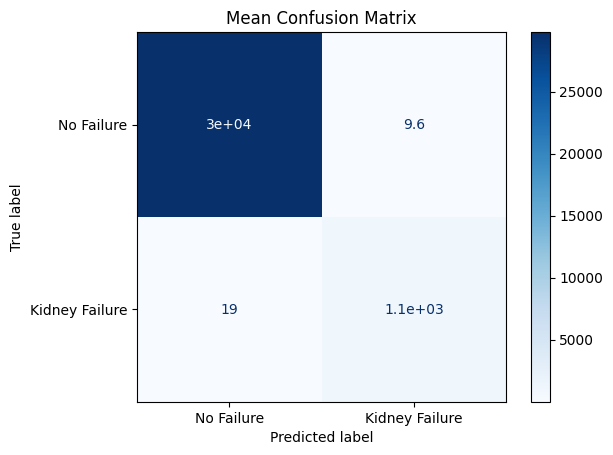

                        Mean  Standard Deviation
TruePositives    1089.200000            9.257429
TrueNegatives   29785.000000            3.535534
FalsePositives      9.600000            3.361547
FalseNegatives     19.400000            9.659193
TPR                 0.982503            0.008706
TNR                 0.999678            0.000113
FPR                 0.000322            0.000113
FNR                 0.017497            0.008706
Accuracy            0.999062            0.000369
Precision           0.991263            0.003052
Recall              0.982503            0.008706
f1_score            0.986850            0.005208
Specificity         0.999678            0.000113
ROC-AUC             0.999774            0.000112
Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 50}


In [27]:
# Given the best seed, find the optimial hyperparameters.

# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives',
                                   'TPR', 'TNR', 'FPR', 'FNR',
                                   'Accuracy', 'Precision', 'Recall', 'f1_score', 'Specificity', 'ROC-AUC'])

# Sample dataset features and target
features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X = AU_df[features]
y = AU_df['Kidney_Failure']

# Initialize accumulators for confusion matrix elements
total_true_positives = 0
total_true_negatives = 0
total_false_positives = 0
total_false_negatives = 0

# Initialize a Decision Tree model
clf =  lgb.LGBMClassifier(objective='binary', random_state=seed_value)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50],
    'min_child_samples': [20, 30]
}

# Initialize GridSearch
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value),
                           scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit the GridSearch model
grid_search.fit(X, y)

# Extract the best estimator
best_clf = grid_search.best_estimator_

# Use Stratified KFold for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_value)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model using the best estimator
    best_clf.fit(X_train, y_train)

    # Evaluate on the held-out test set
    y_pred = best_clf.predict(X_test)
    print("Final Accuracy:", accuracy_score(y_test, y_pred))
    print("Final Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Final ROC-AUC Score:")
    print(roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1]))

    # Compute the statistics
    true_positives = np.sum((y_pred == 1) & (y_test == 1))
    true_negatives = np.sum((y_pred == 0) & (y_test == 0))
    false_positives = np.sum((y_pred == 1) & (y_test == 0))
    false_negatives = np.sum((y_pred == 0) & (y_test == 1))

    # Accumulate confusion matrix values
    total_true_positives += true_positives
    total_true_negatives += true_negatives
    total_false_positives += false_positives
    total_false_negatives += false_negatives

    # Print individual metrics
    tpr = true_positives / (true_positives + false_negatives)
    tnr = true_negatives / (true_negatives + false_positives)
    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score = 2 * precision * recall / (precision + recall)
    specificity = true_negatives / (true_negatives + false_positives)
    roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])

    print(accuracy, precision, recall, f1_score, specificity, roc_auc)

    # Add the statistics to the dataframe
    df_results.loc[len(df_results)] = [true_positives, true_negatives, false_positives, false_negatives, tpr, tnr, fpr, fnr, accuracy, precision, recall, f1_score, specificity, roc_auc]

# Compute mean confusion matrix values
mean_true_positives = total_true_positives / n_splits
mean_true_negatives = total_true_negatives / n_splits
mean_false_positives = total_false_positives / n_splits
mean_false_negatives = total_false_negatives / n_splits

# Construct the mean confusion matrix
mean_confusion_matrix = np.array([[mean_true_negatives, mean_false_positives],
                                 [mean_false_negatives, mean_true_positives]])

# Plot the mean confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=mean_confusion_matrix, display_labels=['No Failure', 'Kidney Failure'])
cm_display.plot(cmap='Blues')  # Using the 'Blues' colormap
plt.title('Mean Confusion Matrix')
plt.show()

# Print the average of each statistic over the 5 folds
#print(df_results.mean())

# Print the average and standard deviation of each statistic over the 5 folds
mean_results = df_results.mean()
std_results = df_results.std()

# Create a new DataFrame to display mean and standard deviation
results_summary = pd.DataFrame(index=mean_results.index)
results_summary['Mean'] = mean_results
results_summary['Standard Deviation'] = std_results

print(results_summary)

# Print out the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

In [28]:
# Train the final model on the full Australian dataset with the most optimal hyperparameters.
best_clf = lgb.LGBMClassifier(**best_params, random_state=seed_value)
best_clf.fit(X, y)

[LightGBM] [Info] Number of positive: 5543, number of negative: 148973
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 154516, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035873 -> initscore=-3.291229
[LightGBM] [Info] Start training from score -3.291229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(learning_rate=0.2, max_depth=7, num_leaves=50, random_state=0)

In [29]:
# Get feature importances
importances = best_clf.feature_importances_

# Pair feature names with their importance values
feature_importance_pairs = list(zip(features, importances))

# Sort by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display the sorted features and their importances
for rank, (feature, importance) in enumerate(sorted_feature_importance_pairs, start=1):
    print(f"{rank}.\tfeature {feature} ({importance:.6f})")

1.	feature eGFR_slope (1744.000000)
2.	feature eGFR_mean (1649.000000)
3.	feature AGE (1301.000000)
4.	feature SEX (177.000000)


### HELD-OUT TEST DATA - Tuned Model (Without Fine-Tuning)

In [30]:
JP_df = process_dataframe(file_path_JP_preprocessed)
JP_df

<ipython-input-23-d26d83f09be9>:40: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  JP_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']


,ID,SEX,Time,AGE,eGFR,Kidney_Failure,Months,COLLECTED,eGFR_slope,eGFR_mean,eGFR_std
0,10101,2,eGFR(0M),74,44.685607,0,0,737425.0,-0.015137,29.643276,7.328739
1,10101,2,eGFR(6M),74,33.702778,0,6,737607.0,-0.015137,29.643276,7.328739
2,10101,2,eGFR(12M),75,30.641655,0,12,737791.0,-0.015137,29.643276,7.328739
3,10101,2,eGFR(18M),75,31.129969,0,18,737972.0,-0.015137,29.643276,7.328739
4,10101,2,eGFR(24M),76,26.807906,0,24,738156.0,-0.015137,29.643276,7.328739
...,...,...,...,...,...,...,...,...,...,...,...
3383,160112,1,eGFR(18M),53,35.133304,0,18,737972.0,-0.001151,36.370115,2.238376
3384,160112,1,eGFR(24M),54,35.502557,0,24,738156.0,-0.001151,36.370115,2.238376
3385,160112,1,eGFR(30M),54,33.338440,0,30,738337.0,-0.001151,36.370115,2.238376
3386,160112,1,eGFR(36M),55,36.758771,0,36,738521.0,-0.001151,36.370115,2.238376


In [31]:
# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Dataset features and target
features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X_test = JP_df[features]
y_test = JP_df['Kidney_Failure']

# Evaluate on the held-out test set
clf = best_clf

y_pred = clf.predict(X_test)
print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Final Classification Report:")
print(classification_report(y_test, y_pred))
print("Final ROC-AUC Score:")
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# Compute the statistics
true_positives = np.sum((y_pred == 1) & (y_test == 1))
true_negatives = np.sum((y_pred == 0) & (y_test == 0))
false_positives = np.sum((y_pred == 1) & (y_test == 0))
false_negatives = np.sum((y_pred == 0) & (y_test == 1))

# Print individual metrics
tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2 * precision * recall / (precision + recall)
specificity = true_negatives / (true_negatives + false_positives)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print("TPR: {:.6g}".format(tpr), "TNR: {:.6g}".format(tnr), "FPR: {:.6g}".format(fpr), "FNR: {:.6g}".format(fnr),
      '\n' "Accuracy: {:.6g}".format(accuracy), "Precision: {:.6g}".format(precision), "Recall: {:.6g}".format(recall), "F1 Score: {:.6g}".format(f1_score), "Specificity: {:.6g}".format(specificity), "ROC-AUC: {:.6g}".format(roc_auc))

Final Accuracy: 0.8736717827626919
Final Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2932
           1       0.54      0.41      0.47       456

    accuracy                           0.87      3388
   macro avg       0.73      0.68      0.70      3388
weighted avg       0.86      0.87      0.87      3388

Final ROC-AUC Score:
0.899035297144635
TPR: 0.412281 TNR: 0.94543 FPR: 0.0545703 FNR: 0.587719 
Accuracy: 0.873672 Precision: 0.54023 Recall: 0.412281 F1 Score: 0.467662 Specificity: 0.94543 ROC-AUC: 0.899035


### HELD-OUT TEST DATA - Tuned Model (with Fine Tuning)

In [32]:
JP_df = process_dataframe(file_path_JP_preprocessed)
JP_df

<ipython-input-23-d26d83f09be9>:40: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  JP_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']


,ID,SEX,Time,AGE,eGFR,Kidney_Failure,Months,COLLECTED,eGFR_slope,eGFR_mean,eGFR_std
0,10101,2,eGFR(0M),74,44.685607,0,0,737425.0,-0.015137,29.643276,7.328739
1,10101,2,eGFR(6M),74,33.702778,0,6,737607.0,-0.015137,29.643276,7.328739
2,10101,2,eGFR(12M),75,30.641655,0,12,737791.0,-0.015137,29.643276,7.328739
3,10101,2,eGFR(18M),75,31.129969,0,18,737972.0,-0.015137,29.643276,7.328739
4,10101,2,eGFR(24M),76,26.807906,0,24,738156.0,-0.015137,29.643276,7.328739
...,...,...,...,...,...,...,...,...,...,...,...
3383,160112,1,eGFR(18M),53,35.133304,0,18,737972.0,-0.001151,36.370115,2.238376
3384,160112,1,eGFR(24M),54,35.502557,0,24,738156.0,-0.001151,36.370115,2.238376
3385,160112,1,eGFR(30M),54,33.338440,0,30,738337.0,-0.001151,36.370115,2.238376
3386,160112,1,eGFR(36M),55,36.758771,0,36,738521.0,-0.001151,36.370115,2.238376


[LightGBM] [Info] Number of positive: 68, number of negative: 440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.133858 -> initscore=-1.867267
[LightGBM] [Info] Start training from score -1.867267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

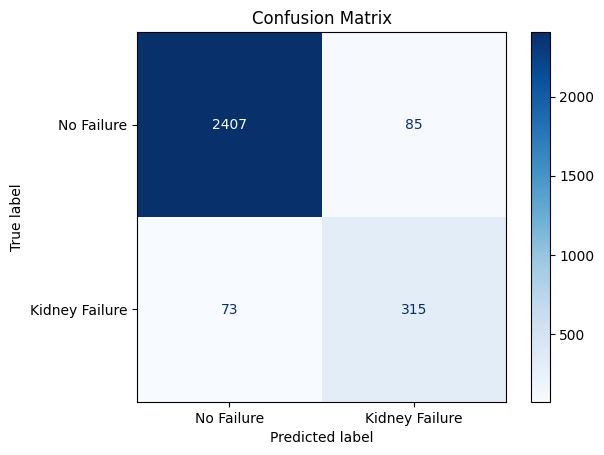

In [33]:
# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# CHANGING TO TUNED MODEL
clf = best_clf

# Adjust this threshold as needed
threshold = 0.5

# Dataset features and target
features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X = JP_df[features]
y = JP_df['Kidney_Failure']

# Train the model on 15% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=seed_value, stratify=y)
clf.fit(X_train, y_train)

# Evaluate on the held-out test set
y_pred = clf.predict(X_test)
print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Final Classification Report:")
print(classification_report(y_test, y_pred))
print("Final ROC-AUC Score:")
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# Compute the statistics
true_positives = np.sum((y_pred == 1) & (y_test == 1))
true_negatives = np.sum((y_pred == 0) & (y_test == 0))
false_positives = np.sum((y_pred == 1) & (y_test == 0))
false_negatives = np.sum((y_pred == 0) & (y_test == 1))

# Print individual metrics
tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2 * precision * recall / (precision + recall)
specificity = true_negatives / (true_negatives + false_positives)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print("TPR: {:.6g}".format(tpr), "TNR: {:.6g}".format(tnr), "FPR: {:.6g}".format(fpr), "FNR: {:.6g}".format(fnr),
      '\n' "Accuracy: {:.6g}".format(accuracy), "Precision: {:.6g}".format(precision), "Recall: {:.6g}".format(recall), "F1 Score: {:.6g}".format(f1_score), "Specificity: {:.6g}".format(specificity), "ROC-AUC: {:.6g}".format(roc_auc))

# Plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Failure', 'Kidney Failure'])

cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Get feature importances
importances = best_clf.feature_importances_

# Pair feature names with their importance values
feature_importance_pairs = list(zip(features, importances))

# Sort by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display the sorted features and their importances
for rank, (feature, importance) in enumerate(sorted_feature_importance_pairs, start=1):
    print(f"{rank}.\tfeature {feature} ({importance:.6f})")

1.	feature eGFR_slope (659.000000)
2.	feature eGFR_mean (452.000000)
3.	feature AGE (364.000000)
4.	feature SEX (31.000000)
